# TensorFlow Parte IV - Derivación Automática

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2023-09-08 12:55:42.111766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 12:55:42.877886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Cintas de gradientes (*gradient tapes*)

TensorFlow provee el API `tf.GradientTape` para derivación automática. TensorFlow puede "grabar" las operaciones relevantes ejecutadas dentro del contexto de un `tf.GradientTape` en una "cinta". Después, ocupa esa cinta para calcular los gradientes del cómputo "grabado" con derivación en modo hacia atrás (*reverse mode*).

In [2]:
x = tf.Variable(3.0)

2023-09-08 13:07:08.357120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 13:07:08.364663: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
with tf.GradientTape() as tape:
    y = x**2

Después de grabar las operaciones con la cinta, podemos usar `GradientTape.gradient(función, variable)` para derivar:

In [4]:
dy_dx = tape.gradient(y, x)

In [5]:
dy_dx.numpy()

6.0

Ele ejemplo arriba es con escalares, pero podemos usar cualquier tensor:

In [6]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')

In [7]:
x = [[1., 2., 3.]]

In [11]:
with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    perdida = tf.reduce_mean(y**2)

Para obtener el gradiente de `perdida` con respecto a ambas variables podemos pasar ambas como "fuentes" al método `gradient`. A la cinta no le importa como pasamos las "fuentes": puede ser cualquier combinación anidada de listas o diccionarios, y devolverá los gradientes con la misma estructura.

In [12]:
[dl_dw, dl_db] = tape.gradient(perdida, [w, b])

In [13]:
dl_dw, dl_db

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 4.9130287,  8.6937065],
        [ 9.826057 , 17.387413 ],
        [14.739086 , 26.08112  ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.9130287, 8.6937065], dtype=float32)>)

El gradiente con respecto a la variable tiene la misma forma que la variable.

In [16]:
print(w.shape)

(3, 2)


In [17]:
print(dl_dw.shape)

(3, 2)


Hacemos lo mismo, pero ahora con un diccionario:

In [18]:
mi_vars = {
    'w': w,
    'b': b
}

In [19]:
grad = tape.gradient(perdida, mi_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.9130287, 8.6937065], dtype=float32)>

## Gradientes de un modelo

Es común unir `tf.Variable`s en un `tf.Module` o una de sus subclases (`layers.Layer`, `keras.Model`).

En la mayoría de los casos, vas a querer calcular los gradientes con respecto a las variables entrenables de un modelo. Ya que todas las subclases de `tf.Module` juntan sus variables en la propiedad `Module.trainable_variables` es bastante fácil:

In [22]:
# Primer ejemplo del uso de Keras! 
# Este es para crear una capa de neuronas completamente conectadas
layer = tf.keras.layers.Dense(2, activation='relu')

In [23]:
x = tf.constant([[1., 2., 3.]])

In [24]:
with tf.GradientTape() as tape:
    y = layer(x)
    perdida = tf.reduce_mean(y**2)

In [25]:
grad = tape.gradient(perdida, layer.trainable_variables)

In [26]:
for var, g in zip(layer.trainable_variables, grad):
    print(f'{var.name}, shape: {g.shape}')

dense_2/kernel:0, shape: (3, 2)
dense_2/bias:0, shape: (2,)


## Controlando lo que la cinta monitorea

Por defect, la cinta graba todas las operaciones después de acceder a una variable de tipo `tf.Variable` que es entrenable.

El siguiente código no calcula un gradiente porque un objeto de tipo `tf.Tensor` no está monitoreado por defecto, y la `tf.Variable` no es entrenable:

In [27]:
x0 = tf.Variable(3.0, name='x0') #Entrenable
x1 = tf.Variable(3.0, name='x1', trainable=False) #No entrenable
x2 = tf.Variable(2.0, name='x2') + 1.0 #Variable + Tensor = Tensor
x3 = tf.constant(3.0, name='x3') # No es una variable

In [28]:
with tf.GradientTape() as tape:
    y = (x0**2) + (x1**2) + (x2**2)

In [29]:
grad = tape.gradient(y, [x0, x1, x2, x3])

In [30]:
for g in grad:
    print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


Podemos las variables monitoreados por la cinta con el método `GradientTape.watched_variables`:

In [31]:
[var.name for var in tape.watched_variables()]

['x0:0']

Se puede especificar que queremos monitorear en la cinta usando `GradientTape.watch(x)`:

In [32]:
x = tf.constant(3.0)

In [33]:
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2

In [34]:
dy_dx = tape.gradient(y, x)

In [35]:
print(dy_dx.numpy())

6.0


También es posible desactivar el monitoreo de todas las variables por el uso de `watch_accessed_variables=False`:

In [36]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

In [37]:
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1)
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1)
    y = y0 + y1
    ys = tf.reduce_sum(y)

In [38]:
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

In [39]:
print('dy/dx0:', grad['x0']) #No estaba incluida en la cinta...
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


## Resultados intermedios

Se puede calcular gradientes de la salida con respecto a valores intermedios calculados adentro del contexto de la cinta:

In [40]:
x = tf.constant(3.0)

In [41]:
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x*x
    z = y*y

In [42]:
print(tape.gradient(z, y).numpy())

18.0


Por defecto, los recursos asignados a una `GradientTape` están liberados el momento que se usa el método `GradientTape.gradient`.

Para calcular multiples gradientes, se puede usar la opción `persistent=True`. En este caso se puede llamar al método `gradient` varias veces, y los recursos de la cinta se liberan automáticamente (*garbage collection*).

In [43]:
x = tf.constant([1, 3.0])

In [44]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x * x
    z = y * y

In [47]:
print(tape.gradient(z, x).numpy())

[  4. 108.]


In [46]:
print(tape.gradient(y, x).numpy())

[2. 6.]


In [49]:
del tape #Para eliminar la cinta

NameError: name 'tape' is not defined

In [50]:
print(tape.gradient(y, x).numpy())

NameError: name 'tape' is not defined

* Hay un costo (pequeño) de tiempo de cómputo en el uso del contexto de `GradientTape`, así que mejor usarlo solamente cuando sea necesario.


* Hay un costo también de memoria. Con `persistent=True` **todo** está grabado, así que el uso de memoría puede crecer bastante.

## Gradientes de varias funciones

Un gradiente es, fundamentalmente, una operación en un escalar.

In [51]:
x = tf.Variable(2.0)

In [52]:
with tf.GradientTape(persistent=True) as tape:
    y0 = x**2
    y1 = 1 / x

In [53]:
print(tape.gradient(y0, x).numpy())

4.0


In [54]:
print(tape.gradient(y1, x).numpy())

-0.25


Si pedimos el gradiente de varias funciones (*targets*), el resultado para cada variable (*source*) es:

* El gradiente de la **suma** de las funciones


* La suma de los gradientes (equivalente).

In [55]:
x = tf.Variable(2.0)

In [56]:
with tf.GradientTape() as tape:
    y0 = x**2
    y1 = 1 / x

In [57]:
print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


In [58]:
x = tf.Variable(2.)

In [59]:
with tf.GradientTape() as tape:
    y = x * [3., 4.]

In [60]:
print(tape.gradient(y, x).numpy())

7.0


En el caso abajo, podemos obtener el gradiente (derivada con respecto a $x$) de una función en todos los valores de $x$ porque trata cada elemento del arreglo como un elemento independiente.

In [ ]:
x = tf.linspace(-10.0, 10.0, 200+1)

In [62]:
with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)

In [63]:
dy_dx = tape.gradient(y, x)

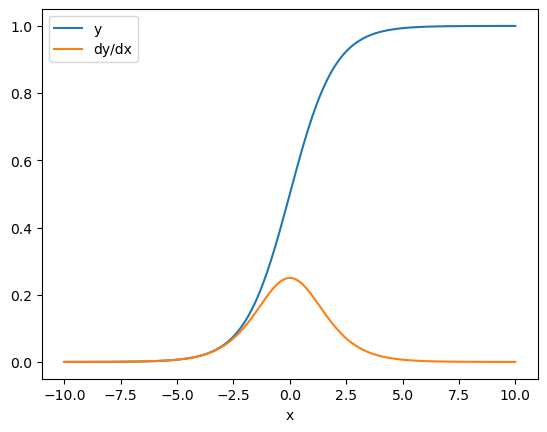

In [64]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## Flujo de control

Ya que una cinta graba operaciones cuando están ejecutadas, el flujo de control de Python está incorporado naturalmente (por ejemplo, `if` y `while`).

In [65]:
x = tf.constant(1.0)

In [66]:
v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

In [67]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    if x > 0.0:
        result = v0
    else:
        result = v1**2

In [68]:
dv0, dv1 = tape.gradient(result, [v0, v1])

In [69]:
print(dv0)

tf.Tensor(1.0, shape=(), dtype=float32)


In [70]:
print(dv1)

None


El resultado arriba depende de si $x > 0$ o no. La derivada con respecto a $x$ es siempre `None`.

In [ ]:
dx = tape.gradient(result, x)

In [72]:
print(dx)

None


## Casos donde el gradiente devuelve `None`

Si una función no depende de una variable, el gradiente es `None` (*a target is not connected to a source*)

In [73]:
x = tf.Variable(2.)
y = tf.Variable(3.)

In [74]:
with tf.GradientTape() as tape:
    z = y * y

In [75]:
print(tape.gradient(z, x))

None


Hay otras circunstancias donde un gradiente puede resultar "descontectado" de una variable:

### 1. Reemplazar una variable por un tensor

Ya que la cinta monitorea objetos de tipo `tf.Variable`, pero no de tipo `tf.Tensor`, un error común es reemplazar una `tf.Variable` por un `tf.Tensor`, en vez de usar `Variable.assign` para actualizar la variable.

In [76]:
x = tf.Variable(2.0)

In [78]:
for epoch in range(2):
    with tf.GradientTape() as tape:
        y = x+1
        
    print(type(x).__name__, ":", tape.gradient(y, x))
    x = x + 1 #Este debería ser x.assign_add(1)

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


### 2. Cálculos realizados fuera de TensorFlow

La cinta no puede grabar el camino del gradiente si el cálculo sale de TensorFlow:

In [79]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

In [80]:
with tf.GradientTape() as tape:
    x2 = x**2
    
    #Este es con NumPy, no TF
    y = np.mean(x2, axis=0)
    
    #Este va a convertir un arreglo de NumPy a un tensor constante
    #con tf.convert_to_tensor
    y = tf.reduce_mean(y, axis=0)

In [81]:
print(tape.gradient(y, x))

None


### 3. Pasar gradientes a través de un entero o *string*

Enteros y *strings* no son diferenciables. Si el camino de un cálculo utiliza estos tipos, no hará gradiente.

In [82]:
x = tf.constant(10)

In [83]:
with tf.GradientTape() as g:
    g.watch(x)
    y = x * x

In [84]:
print(g.gradient(y, x))

None


### 4. Pasar gradientes a través de un objeto con estado

Cuando se lee de un objeto con un estado, la cinta solamente puede observar el estado actual, no la historia de como llegó a ese estado.

Un `tf.Tensor` es inmutable. Tiene **valor** pero no tiene **estado**. Todas las operaciones que hemos visto hasta ahora también son sin estado: la salida de `tf.matmul` depende solamente de las entradas.

Una `tf.Variable` tiene un estado interno, su valor. Cuando se usa la variable, se lee su estado. Es normal calcular un gradiente con respecto a una variable, pero su estado bloquea ls posibilidad de extender los cálculos de los gradientes más allá. Por ejemplo:

In [85]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

In [86]:
with tf.GradientTape() as tape:
    # Actualizar x1 = x1 + x0
    x1.assign_add(x0)
    
    # La cinta comienza grabando desde x1
    y = x1**2

In [87]:
print(tape.gradient(y, x0))

None


Objetos como iteradores de tipo `tf.data.Dataset` y objetos de `tf.queue` tienen estado, así que bloquean todos los gradientes de tensores que pasan por esos objetos.

## No hay gradiente registrado

Algunas `tf.Operation`s son registrados como no-diferenciable y devuelven `None`. Otras no tienen gradientes registrados.

Hay una [lista](https://www.tensorflow.org/api_docs/python/tf/raw_ops) de operaciones de bajo nivel (`tf.raw_ops`) con gradientes registrados.

Pasando un gradiente a través de una operación de `float` que no tiene un gradiente registrado resulta en un error. 

Por ejemplo, la función `tf.image.adjust_contrast` envuelve `raw_ops.AdjustContrastv2` que podría tener un gradiente pero no está implementado:

In [88]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

In [90]:
with tf.GradientTape() as tape:
    new_image = tf.image.adjust_contrast(image, delta)

In [91]:
try:
    print(tape.gradient(new_image, [image, delta]))
    assert False # Este no debería pasar
except LookupError as e:
    print(f'{type(e).__name__}: {e}')

LookupError: gradient registry has no entry for: AdjustContrastv2


Se puede implementar gradientes y registrarlos (con `tf.RegisterGradient`).

## Ceros en vez de `None`

En el caso de tener gradientes "desconectados" se puede especificar usar $0$ en vez de `None`:

In [92]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

In [93]:
with tf.GradientTape() as tape:
    z = y**2

In [94]:
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
